In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [20]:
def calculate_confidence_interval(data, window, min_periods, z_score_threshold):
    # Calculate the rolling mean and standard deviation
    mean = data.rolling(window=window, min_periods=min_periods).mean()
    std = data.rolling(window=window, min_periods=min_periods).std()

    # Calculate the upper and lower bounds of the confidence interval
    lower_bound = mean - z_score_threshold * std
    upper_bound = mean + z_score_threshold * std

    return pd.DataFrame({'LowerBound': lower_bound, 'UpperBound': upper_bound})

In [21]:
def plot_with_confidence_interval(data, confidence_interval, outliers, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Data')
    plt.fill_between(data.index, confidence_interval['LowerBound'], confidence_interval['UpperBound'], color='red', alpha=0.1)
    plt.scatter(data.index[outliers], data.iloc[outliers], color='orange', label='Outliers')
    
    # Fit a line to the data and plot it
    z = np.polyfit(range(len(data)), data, 1)
    p = np.poly1d(z)
    plt.plot(data.index, p(range(len(data))), "r--", label='Line of Best Fit')

    # Fit an exponential function to the data and plot it
    # log_y = np.log(data)
    # z = np.polyfit(range(len(data)), log_y, 1)
    # p = np.poly1d(z)
    # plt.plot(data.index, np.exp(p(range(len(data)))), "r--", label='Exponential Fit')
    
    plt.title(title)
    plt.legend()
    plt.show()

In [22]:
def plot_with_confidence_interval_and_forecast_outliers(actual_data, confidence_interval, forecast_data, forecast_outliers, title):
    plt.figure(figsize=(10, 5))
    plt.plot(actual_data, label='Actual Data')
    plt.fill_between(actual_data.index, confidence_interval['LowerBound'], confidence_interval['UpperBound'], color='red', alpha=0.1, label='Confidence Interval')
    
    # Plot the forecast data, distinguishing between outliers and non-outliers
    plt.scatter(forecast_data.index, forecast_data['Forecast_3m'], c='b', label='Forecast (Non-Outliers)')
    plt.scatter(forecast_data.index[forecast_outliers], forecast_data['Forecast_3m'].iloc[forecast_outliers], c='orange', label='Forecast (Outliers)')
    
    plt.title(title)
    plt.legend()
    plt.show()

In [23]:
# Load the actual data from the Excel file
actual_data = pd.read_excel('platform_3m_actuals_new.xlsx')

# Filter the data to only include the "8k chassis" platform
actual_data = actual_data[actual_data['Platform'] == '8k_Chassis']


In [24]:
# Convert 'datestamp' to datetime and sort by it
actual_data['datestamp'] = pd.to_datetime(actual_data['datestamp'])
actual_data.sort_values('datestamp', inplace=True)

# Set 'datestamp' as the index and format it to show month and year
actual_data.set_index('datestamp', inplace=True)
actual_data.index = actual_data.index.strftime('%b %Y')

In [25]:
# Load the forecast data
forecast_data = pd.read_csv('mviai_platform_3m_forecast.csv')

In [26]:
# Prepare the data for clustering
X = forecast_data['Forecast_3m'].values.reshape(-1, 1)

In [27]:
# Define the DBSCAN model
eps_value = 500  # this is the maximum distance between two samples for them to be considered as in the same neighborhood
min_samples_value = 5  # the number of samples in a neighborhood for a point to be considered as a core point
db = DBSCAN(eps=eps_value, min_samples=min_samples_value)

In [28]:
# Fit the DBSCAN model to the actual data
db.fit(X)

# Use the DBSCAN model to predict whether each point in the forecast data is an outlier
forecast_labels = db.fit_predict(forecast_data['Forecast_3m'].values.reshape(-1, 1))

# Find the indices of the outliers in the forecast data
forecast_outlier_indices = np.where(forecast_labels == -1)

Number of outliers in the forecast data: 277
             Platform  Bookings_3m  Booking_Cost_3m  Customer_Count  \
datestamp                                                             
Oct 2019   8k_Chassis          4.0         554.1315        1.000000   
Jan 2020   8k_Chassis         36.0      159008.7300        2.000000   
Apr 2020   8k_Chassis         29.0       86121.3400        6.435112   
Jul 2020   8k_Chassis        124.0      296642.3800       11.693187   
Oct 2020   8k_Chassis        724.0      226444.5600        6.018927   
Jan 2021   8k_Chassis       4135.0      442931.9400        1.974265   
Apr 2021   8k_Chassis       1586.0      115041.6700        3.764359   
Jul 2021   8k_Chassis       1102.0      172381.7500        6.398777   
Oct 2021   8k_Chassis       3424.0      252413.6100        1.271224   
Jan 2022   8k_Chassis       2433.0      158047.4200        1.871127   
Apr 2022   8k_Chassis       9657.0      448956.2500        1.000000   

            Run_Rate    Age_STD

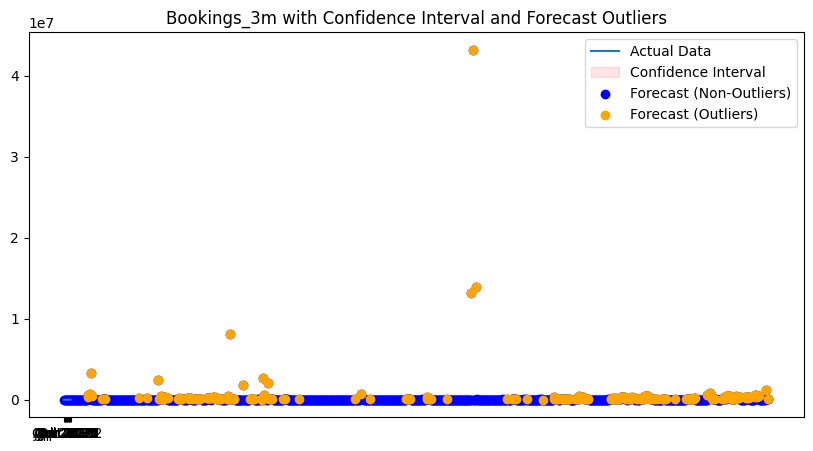

In [29]:
# Print the number of outliers in the forecast data
print('Number of outliers in the forecast data:', len(forecast_outlier_indices[0]))

# Calculate the confidence interval for the 'Bookings_3m' column in the actual data
confidence_interval = calculate_confidence_interval(actual_data['Bookings_3m'], window=3, min_periods=1, z_score_threshold=3)

print(actual_data)

# Plot the 'Bookings_3m' column in the actual data with confidence interval and outliers
plot_with_confidence_interval_and_forecast_outliers(actual_data['Bookings_3m'], confidence_interval, forecast_data, forecast_outlier_indices, title='Bookings_3m with Confidence Interval and Forecast Outliers')